In [86]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial as P
import numdifftools as nd
import torch
import time


# Battery Class Definition Template
class Battery():
    # Defining global static class variables
    global SOC_x, cum_deg_y, i_x, psi_y
    
    # Cumulative degredation mapping manually determined based on fig 4 in the paper
    SOC_x = np.linspace(0.0, 100.0, num=11)
    cum_deg_y = np.array([0.0, 39.0, 47.0, 75.0, 75.0, 84.0, 101.0, 160.0, 269.0, 325.0, 372.0])
    
    # Psi scaling factor using experimental data to linearly interpolate depending on current
    i_x = np.array([0.0, 1.0, 2.0])
    psi_y = np.array([0.0, 1.0, 1.2956])
    
    
    # Initialize with instance variables for battery charging/degradation
    
    # SOC --> State of charge [represents measure of remaining capacity in percentage form]
    # V_nom --> Nominal Voltage [Volts]
    # P_ch_max --> Max power oup
    # charging --> boolen: True if charging, False if dissipating
    # eta --> Battery inefficiency constant (this is approximation from [2])
    def __init__(self):
        # Constants
        self.V_nom = 3.7            # [Volts] constant nominal operating voltage
        self.IC1 = 2.15             # [Amps] constant 1C rate current
        self.P_ch_max = 5           # [Watt] --> do research to determine starting value
        self.deltaT = 1             # [Hours] Duration of trading interval  
        
        # Variables
        self.SOC = None             # [Percentage] current battery percentage
        self.SOC_prev = None        # [Percentage] previous battery percentage
        self.d_t1C = None           # [Amp Hours] degredation at 1C charge during one time interval
        self.psi_t = None           # [unitless] scaling factor of degredation depending on current
        self.d_t = None             # [Amp Hours] total degredation at time interval t
        self.P_ch_b = None          # [Watt] current charge power input to battery
        self.SOC_penalty = 0.0      # SOC constraint violation penalty
        
        
    def setSOC(self, val):
        # updates the SOC
        self.SOC = val
        self.SOC_penalty += np.square(np.maximum(val - 100, 0))
        self.SOC_penalty += np.square(np.minimum(val, 0))
        
        #Ensure that SOC lies in between 0 and 100 (constraint 7)
        self.SOC = np.maximum(0, self.SOC)
        self.SOC = np.minimum(100, self.SOC)
              
                
    def updateSOC(self):
        # Updates the SOC from one trading interval to the next    
        self.SOC_prev = self.SOC
        new_SOC = self.SOC_prev + 100 * ((self.P_ch_b * self.deltaT) / (self.V_nom * self.IC1))
        self.setSOC(new_SOC)
    
    
    def getD_t1C(self):
        # Calculate d_t1C = abs(delta_t - delta_t-1)
        delta1C = np.interp(self.SOC, SOC_x, cum_deg_y)
        delta1C_prev = np.interp(self.SOC_prev, SOC_x, cum_deg_y)
        d_t1C = np.abs(delta1C - delta1C_prev)
        self.d_t1C = d_t1C
    

    def getPsi(self):
        # Calculate i_t and use to determine psi degradation scaling factor
        i_t = np.abs(self.P_ch_b) / (self.V_nom * self.IC1)
        psi_t = np.interp(i_t, i_x, psi_y)
        self.psi_t = psi_t
        
        
    def getD_t(self):
        # Calculate d_t as a function of d_t1C and psi_t
        d_t = ((self.d_t1C + self.psi_t) / 2) ** 2 - ((self.d_t1C - self.psi_t) / 2) ** 2
        self.d_t = d_t
        return d_t
    
    
    def calcIter(self, P_t):
        # loops through iteration to calculate d_t given P_t
        self.P_ch_b = P_t
        self.updateSOC()
        self.getD_t1C()
        self.getPsi()
        d_t = self.getD_t()
        return d_t
    
    
    def calcTotal(self, P, SOC_0=50.0, rho_SOC=1.0, verbose=False):
        # given charging schedule P, calculate final degredation
        self.setSOC(SOC_0)
        self.SOC_penalty = 0.0
        d_ts = []
        if verbose:
            SOC_ts, d_t1cs, psi_ts, SOC_penalties = [], [], [], []
        for t in range(len(P)):
            d_t = self.calcIter(P[t])
            d_ts.append(d_t)
            
            if verbose:
                SOC_ts.append(self.SOC_prev)
                d_t1cs.append(self.d_t1C)
                psi_ts.append(self.psi_t)
                SOC_penalties.append(self.SOC_penalty)
        
        d_ts = np.array(d_ts)
        D = np.sum(d_ts) + rho_SOC * self.SOC_penalty
        if verbose:
            return D, SOC_ts, d_ts, d_t1cs, psi_ts, SOC_penalties
        return D
    

    def plotPsi(self):
        # Plots the psi schedule as a function of i = P / VI
        plt.plot(i_x, psi_y, marker='D')
        plt.xlabel("i")
        plt.ylabel("Psi Degredation Scaling Factor")
        
        
    def plotCum_Deg(self):
        # Plots essentially the same plot as fig 4 in the paper
        plt.plot(SOC_x, cum_deg_y, marker='D')
        plt.xlabel("SOC (%)")
        plt.ylabel("Cumulative Degredation (10^-6 Ah)")
        

In [87]:
# Cost Class Definition Template
class Cost():
    # Initialize with instance variables for cost model

    # eta --> Battery inefficiency constant (this is approximation from [2])
    def __init__(self, t=2):
        # Constants
        self.eta = .95                   # [Constant] Initial guess at inefficiency constant
        self.deltaT = 1                  # [Hours] Duration of trading interval
        self.prices = 0.20 * np.ones(t)  # [Dollars / kWh] prices of electricity over discrete time intervals
    
    
    def calc(self, P):
        # calculates cost C given charging schedule P
        P = np.where(P > 0.0, P / self.eta, P)
        P = np.where(P < 0.0, P * self.eta, P)
        C = np.sum(P * self.prices / 1000) * self.deltaT
        return C


In [120]:
def calcPenalty(P, battery):
    # calculate penalty using quadratic penalty method
    P_max = battery.P_ch_max
    penalty = np.sum(np.square(np.maximum(np.abs(P) - P_max, 0)))
    return penalty


def objective(P, SOC_0=50.0, w_C=0.5, rho=1.0, rho_SOC=1.0, verbose=False):
    if verbose:
        C = cost.calc(P)
        D, SOC_ts, d_ts, d_t1cs, psi_ts, SOC_penalties = bat.calcTotal(P, SOC_0=SOC_0, rho_SOC=rho_SOC, verbose=True)
        cache = P, SOC_ts, d_ts, d_t1cs, psi_ts, SOC_penalties, cost.prices
        penalty = calcPenalty(P, bat)
        objective = (w_C * C * 100000) + (1 - w_C) * D + (rho * penalty)
        return objective, cache
    
    else:
        C = cost.calc(P)
        D = bat.calcTotal(P, SOC_0=SOC_0, rho_SOC=rho_SOC)
        penalty = calcPenalty(P, bat)
        objective = (w_C * C * 100000) + (1 - w_C) * D + (rho * penalty)
        return objective


In [121]:
def normalize(g):
    length = np.linalg.norm(g)
    result = g / length
    return result


def gradient_descent(lr, n_iter, w_C, rho=1.0, rho_SOC=1.0, beta=0.4, lr_decay=1.0):
    P = np.random.uniform(low=-3.0, high=3.0, size=t)
#     P = np.ones(t) * 0
    v = np.zeros(t)
    losses, Ps, grads = [], [], []
    g = nd.Gradient(objective, full_output=True)
    for i in range(n_iter):
        grad, info = g(P, SOC_0=SOC_0, w_C=w_C, rho=rho, rho_SOC=rho_SOC)
        v = beta * v - (lr * normalize(grad))
        P += v
        lr *= lr_decay
        
        grads.append(grad.copy())
        losses.append(info)
        Ps.append(P.copy())
    losses = [i.f_value for i in losses]
    Ps = np.array(Ps)
    return P, grads, losses, Ps


def optimize(lr, n_iter, w_C, rho, rho_SOC, beta, lr_decay, trials=1):
    best_loss = np.inf
    best_P = None
    best_train_cache = None
    
    for i in range(trials):
        P, grads, losses, Ps = gradient_descent(lr, n_iter, w_C, rho, rho_SOC, beta, lr_decay)
        loss = objective(P)
        if loss < best_loss:
            best_loss = loss
            best_P = P
            best_train_cache = grads, losses, Ps
    return best_P, best_train_cache

In [142]:
def plotLoss(train_cache):
    grads, losses, Ps = train_cache
    fig, ax = plt.subplots(2, 2, figsize=(20, 2 * 5))
    ax[0, 0].plot(losses)
    ax[0, 0].set_xlabel("Iteration")
    ax[0, 0].set_ylabel("Objective Function Value")
    
    ax[0, 1].plot(Ps[:, 0])
    ax[0, 1].set_xlabel("Iteration")
    ax[0, 1].set_ylabel("P1 Values (W)")
    
    ax[1, 1].plot(Ps[:, 1])
    ax[1, 1].set_xlabel("Iteration")
    ax[1, 1].set_ylabel("P2 Values (W)")


def plotCache(cache):
    P, SOC_ts, d_ts, d_t1cs, psi_ts, SOC_penalties, prices = cache
    time = np.arange(1, len(P) + 1) * bat.deltaT
    ####### fix costs
    costs = np.array(P) * np.array(prices)
    
    fig, ax = plt.subplots(4, 2, figsize=(20, 4 * 5))
    
    ax[0, 0].set_title("Power Charge Input")
    ax[0, 0].set_ylabel("Power (Watts)")
    ax[0, 0].plot(time, np.zeros_like(time), color='k')
    ax[0, 0].plot(time, P)
    ax[0, 0].set_ylim([-bat.P_ch_max, bat.P_ch_max])
    
    ax[1, 0].set_title("SOC")
    ax[1, 0].set_ylabel("SOC (%)")
    ax[1, 0].plot(time, SOC_ts)
    ax[1, 0].set_ylim([0, 100])
    
    ax[2, 0].set_title("Energy Prices")
    ax[2, 0].set_ylabel("Price ($ / kWh)")
    ax[2, 0].bar(time, prices)
    
    ax[3, 0].set_title("Cost of Energy Consumption")
    ax[3, 0].set_ylabel("Cost ($)")
    ax[3, 0].plot(time, costs)
    ax[3, 0].plot(time, np.zeros_like(time), color='k')
    
    ax[0, 1].set_title("Degredation")
    ax[0, 1].set_ylabel("Degredation (A)")
    ax[0, 1].plot(time, d_ts)
    
    ax[1, 1].set_title("Unnormalized Degredation")
    ax[1, 1].set_ylabel("Degredation (A)")
    ax[1, 1].plot(time, d_t1cs)
    
    ax[2, 1].set_title("Current Dependant Degredation Scaling Factor")
    ax[2, 1].set_ylabel("Psi (unitless)")
    ax[2, 1].plot(time, psi_ts)
    
    ax[3, 1].set_title("Cumulative SOC Infeasability Penalty")
    ax[3, 1].set_ylabel("Penalty (unitless)")
    ax[3, 1].plot(time, SOC_penalties)
    

--- 143.04533886909485 seconds ---


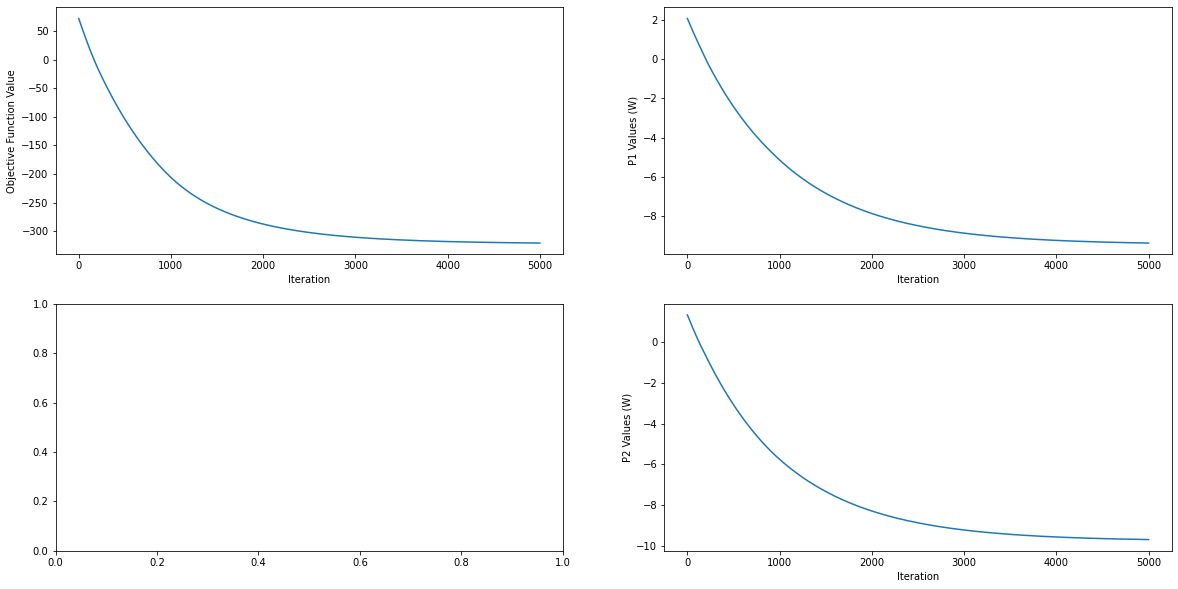

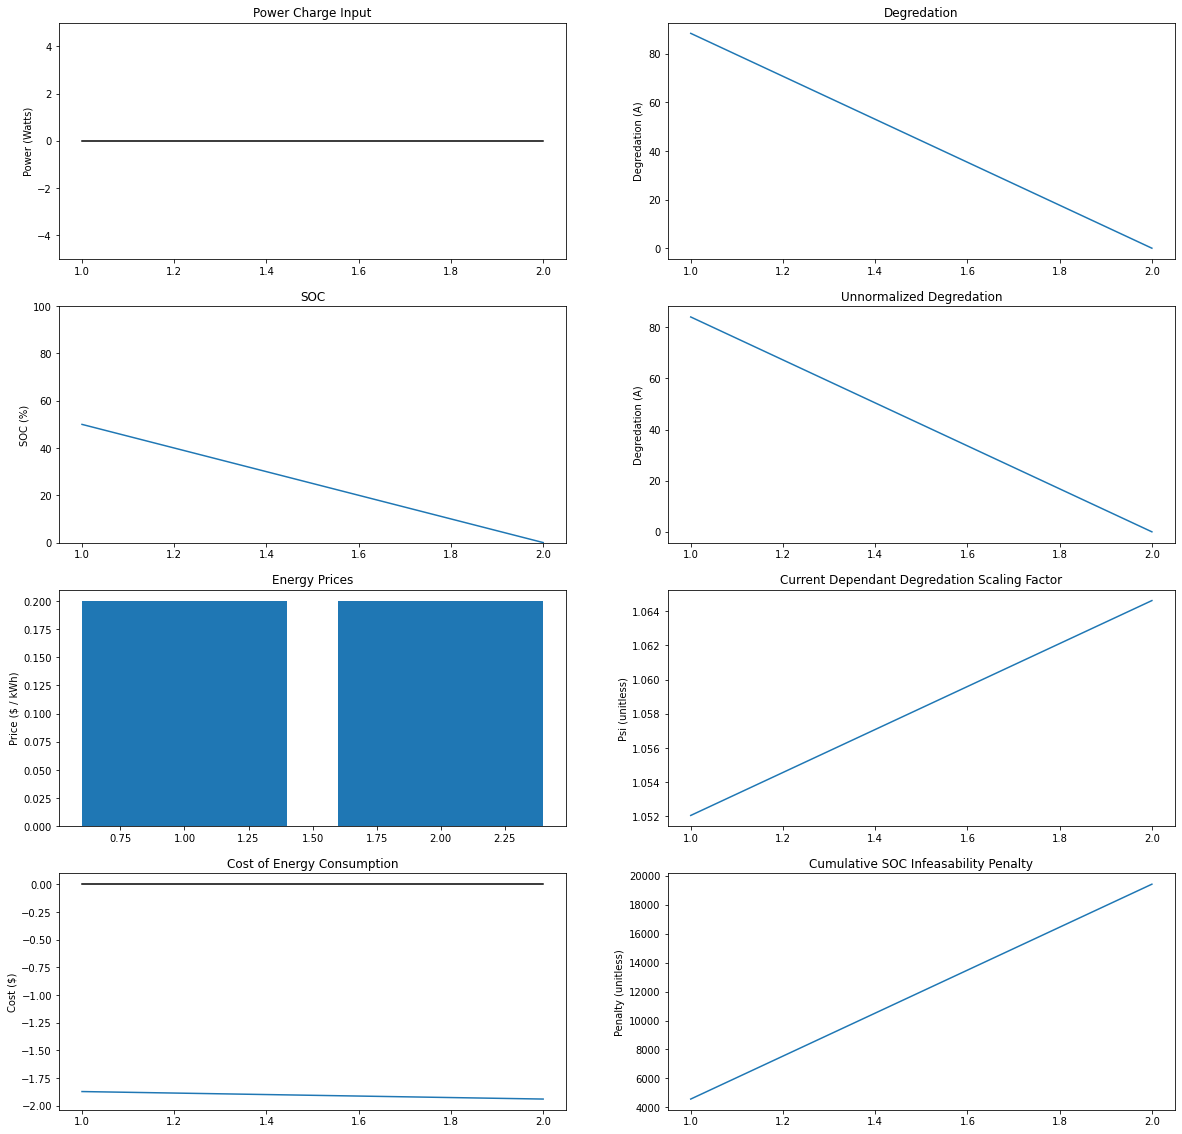

In [144]:
t = 2
w_C = 1.0
SOC_0 = 50.0
lr = 0.008
rho = 1.0
rho_SOC = 1.0
beta = 0.5
lr_decay = 0.999
n_iter = 5000

cost = Cost(t)
bat = Battery()

start_time = time.time()

final_P, train_cache = optimize(lr, n_iter, w_C, rho, rho_SOC, beta, lr_decay, trials=10)
final_f, cache = objective(final_P, verbose=True)
print("--- %s seconds ---" % (time.time() - start_time))

# train_cache = grads, losses, Ps
# cache = P, SOC_ts, d_ts, d_t1cs, psi_ts, SOC_penalties, prices

plotLoss(train_cache)
plotCache(cache)